In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import pathlib
from google.cloud import storage
import tensorflow_hub as hub
from io import BytesIO
from tensorflow.python.lib.io import file_io

In [2]:
train_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren.csv", header=None)
val_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren.csv", header=None)
test_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren.csv", header=None)
CLASS_NAMES = train_data[0].unique()

In [3]:
new_data = train_data.copy()
new_data["Augment"] = False
grouped = train_data.groupby(0).nunique()
max_images = max(grouped[1])

In [8]:
# for img in tqdm(train_data.iterrows()):
#     new_data = new_data.append({0:img[1][0], 1:img[1][1], "Augment": True}, ignore_index=True)

243628it [49:51, 81.43it/s]


In [40]:
for img in tqdm(train_data.iterrows()):
    new_img = max_images // grouped.loc[img[1][0]][1]
    if new_img > 1:
        for i in range(new_img-1):
            new_data = new_data.append({0:img[1][0], 1:img[1][1], "Augment": True}, ignore_index=True)

243628it [1:38:30, 41.22it/s] 


In [9]:
new_data = new_data.sample(frac=1).reset_index(drop=True)


In [10]:
train_data[1][0]

'../gabon-dataset/data_training_rescaled_extra/1305658.jpg'

In [11]:
new_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_augment_siebren.csv", index=None, header=None)

In [40]:
data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_augment_siebren.csv", header=None)

In [42]:
test = data[[0,1]]
test[1] = 1
test.groupby(0).sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,1
0,
Bird,23710
Blank,23956
Buffalo_African,24130
Cat_Golden,24840
Chevrotain_Water,24227
Chimpanzee,24798
Civet_African_Palm,24344
Duiker_Blue,23997
Duiker_Red,23945


In [43]:
print(24840/276)

90.0


# make csv myanmar

In [52]:
df = pd.DataFrame(columns=['class', 'link'])

In [53]:
blank = 0
human = 0
elephant = 0

client = storage.Client()
for blob in tqdm(client.list_blobs('dataset-myanmar-renamed', prefix='human-elephant-blank')):
#     print(blob.name)

    if blob.name[21:26] == "blank":
        df = df.append({"class": "Blank", 'link': "gs://dataset-myanmar-renamed/"+str(blob.name)}, ignore_index=True)
    elif blob.name[21:30] == "elephants":
        df = df.append({"class": "Elephant_African", 'link': "gs://dataset-myanmar-renamed/"+str(blob.name)}, ignore_index=True)
    elif blob.name[21:27] == "humans":
        df = df.append({"class": "Human", 'link': "gs://dataset-myanmar-renamed/"+str(blob.name)}, ignore_index=True)
print("blank: ", blank)
print("human: ", human)
print("elephant: ", elephant)

4628it [00:12, 372.35it/s]

blank:  0
human:  0
elephant:  0


In [10]:
# df = pd.DataFrame(columns=['class', 'link'])

In [5]:
# from google.cloud import storage

# df = pd.DataFrame(columns=['class', 'link'])

# count = 0
# client = storage.Client()
# for blob in tqdm(client.list_blobs('dataset-myanmar-renamed', prefix='renamed')):
#     if count != 0:
#         if blob.name[8:-13] != "Elephant" and blob.name[8:-17] != "Blank" and blob.name[8:-13] != "Blank":
#             df = df.append({"class": "Human", 'link': "gs://dataset-myanmar-renamed/"+str(blob.name)}, ignore_index=True)
#         elif blob.name[8:-13] == "Elephant":
#             df = df.append({"class": "Elephant_African", 'link': "gs://dataset-myanmar-renamed/"+str(blob.name)}, ignore_index=True)
#         elif blob.name[8:-17] == "Blank" or blob.name[8:-13] == "Blank":
#             df = df.append({"class": "Blank", 'link': "gs://dataset-myanmar-renamed/"+str(blob.name)}, ignore_index=True)
#     count+=1

7937it [00:22, 360.11it/s]


In [55]:
drop_list = []
for i in df.iterrows():
    if str(i[1][1][-3:]).lower() != "jpg":
        drop_list.append(i[0])
df = df.drop(drop_list)

In [56]:
df = df.sample(frac=1).reset_index(drop=True)

In [57]:
df.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_siebren.csv", index=None, header=None)

# Change remove low count images

In [46]:
images = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren.csv", header=None)

In [47]:
for idx, image in tqdm(images.iterrows()):
    if image[0] != "Blank" and image[0] != "Human" and image[0] != "Elephant_African":
        images.iloc[idx][0] = "Other_animal"

43612it [00:10, 4288.34it/s]


In [48]:
images.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_4classes_siebren.csv", index=None, header=None)

In [49]:
224000/128

1750.0

# remove labels

In [6]:
def remove_labels(data):
    for idx, row in tqdm(data.iterrows()):
        if row[0] != "Blank" and row[0] != "Human" and row[0] != "Elephant_African":
            data[0][idx] = "Other_animal"
        
remove_labels(train_data)
remove_labels(val_data)
remove_labels(test_data)

243628it [02:45, 1472.95it/s]
60907it [00:20, 2981.51it/s]
43612it [00:13, 3222.67it/s]


In [13]:
new_data = val_data.copy()
new_data["Augment"] = False
grouped = train_data.groupby(0).nunique()
max_images = max(grouped[1])

In [8]:
for img in tqdm(train_data.iterrows()):
    new_img = max_images // grouped.loc[img[1][0]][1]
    if new_img > 1:
        for i in range(new_img-1):
            new_data = new_data.append({0:img[1][0], 1:img[1][1], "Augment": True}, ignore_index=True)

59428it [13:19, 67.88it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

131067it [34:58, 48.00it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

243628it [1:21:08, 50.05it/s]


In [11]:
new_data = new_data.sample(frac=1).reset_index(drop=True)

In [14]:
new_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren_4classes_balanced.csv", header=None, index=None)
# val_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren_4classes.csv", header=None, index=None)
# test_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren_4classes.csv", header=None, index=None)

# remove low count images 2

In [3]:
train = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren.csv", header=None)
val = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren.csv", header=None)

In [4]:
total = train.append(val)
total = total.reset_index(drop=True)

In [5]:
total.groupby(0).nunique()

,1
0,
Bird,5956
Blank,30000
Buffalo_African,5976
Cat_Golden,331
Chevrotain_Water,4317
Chimpanzee,5170
Civet_African_Palm,875
Duiker_Blue,30000
Duiker_Red,29999


small_animal = ['Squirrel', 'Rodent', 'Chevrotain_Water', 'Porcupine_Brush_Tailed', 'Mongoose', 'Genet', 'Mongoose_Black_Footed', 'Civet_African_Palm', 'Pangolin', "Rat_Giant"]
Monkey = ['Monkey', 'Mandrillus', 'Chimpanzee', 'Gorilla']
duiker = ['Duiker_Blue', 'Duiker_Yellow_Backed', Duiker_Red]
Bird = ['Rail_Nkulengu', 'Bird', 'Guineafowl_Crested']
Hog_Red_River
Human
Elephant_African
Leopard_African
Buffalo_African
Cat_Golden <- removed

In [ ]:
def remove_labels(data):
#     pop_list = []
    for idx, row in tqdm(data.iterrows()):
        if row[0] in ['Squirrel', 'Rodent', 'Chevrotain_Water', 'Porcupine_Brush_Tailed', 'Mongoose', 'Genet', 'Mongoose_Black_Footed', 'Civet_African_Palm', 'Pangolin', "Rat_Giant"]:
            data[0][idx] = "Small_animal"
        elif row[0] in ['Monkey', 'Mandrillus', 'Chimpanzee', 'Gorilla']:
            data[0][idx] = "Monkey"
        elif row[0] in ['Duiker_Blue', 'Duiker_Yellow_Backed', "Duiker_Red"]:
            data[0][idx] = "Duiker"
        elif row[0] in ['Rail_Nkulengu', 'Bird', 'Guineafowl_Crested', "Guineafowl_Black"]:
            data[0][idx] = "Bird"
        elif row[0] in ['Cat_Golden', 'Leopard_African']:
            data[0][idx] = "Big cat"
        else:
            pass
#     data.drop(data.index[pop_list], inplace=True)
        
# remove_labels(train_data)
# remove_labels(val_data)
# remove_labels(test_data)

12631it [00:02, 7718.58it/s]

In [31]:
val_data

,0,1
0,Duiker,../gabon-dataset/data_training_rescaled_extra/...
1,Bird,../gabon-dataset/data_training_rescaled_extra/...
2,Bird,../gabon-dataset/data_training_rescaled_extra/...
3,Duiker,../gabon-dataset/data_training_rescaled_extra/...
4,Elephant_African,../gabon-dataset/data_training_rescaled_extra/...
...,...,...
60902,Duiker,../gabon-dataset/data_training_rescaled_extra/...
60903,Duiker,../gabon-dataset/data_training_rescaled_extra/...
60904,Human,../gabon-dataset/data_training_rescaled_extra/...
60905,Bird,../gabon-dataset/data_training_rescaled_extra/...


In [32]:
test_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren_grouped_classes_balanced2.csv", header=None, index=None)

In [27]:
new_data = val_data.copy()
new_data["Augment"] = False
grouped = train_data.groupby(0).nunique()
max_images = max(grouped[1])

In [15]:
for img in tqdm(val_data.iterrows()):
    new_img = max_images // grouped.loc[img[1][0]][1]
    if new_img > 1:
        for i in range(new_img-1):
            new_data = new_data.append({0:img[1][0], 1:img[1][1], "Augment": True}, ignore_index=True)

243628it [1:04:40, 62.79it/s] 


In [16]:
new_data = new_data.sample(frac=1).reset_index(drop=True)

In [24]:
new_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren_grouped_classes_balanced.csv", header=None, index=None)

In [12]:
train_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren_grouped_classes2.csv", header=None, index=None)
val_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren_grouped_classes2.csv", header=None, index=None)
test_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren_grouped_classes2.csv", header=None, index=None)

In [10]:
train_data.groupby(0).nunique()

,1
0,
Bird,17866
Blank,23956
Buffalo_African,4826
Duiker,59479
Elephant_African,24054
Hog_Red_River,18020
Human,24104
Leopard_African,1216
Monkey,12925


In [8]:
def show_img(filename):
    img = tf.io.read_file(filename=filename)
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    plt.figure(figsize = (16,16))
    plt.imshow(img)
    return img

In [1]:
1000/60

16.666666666666668

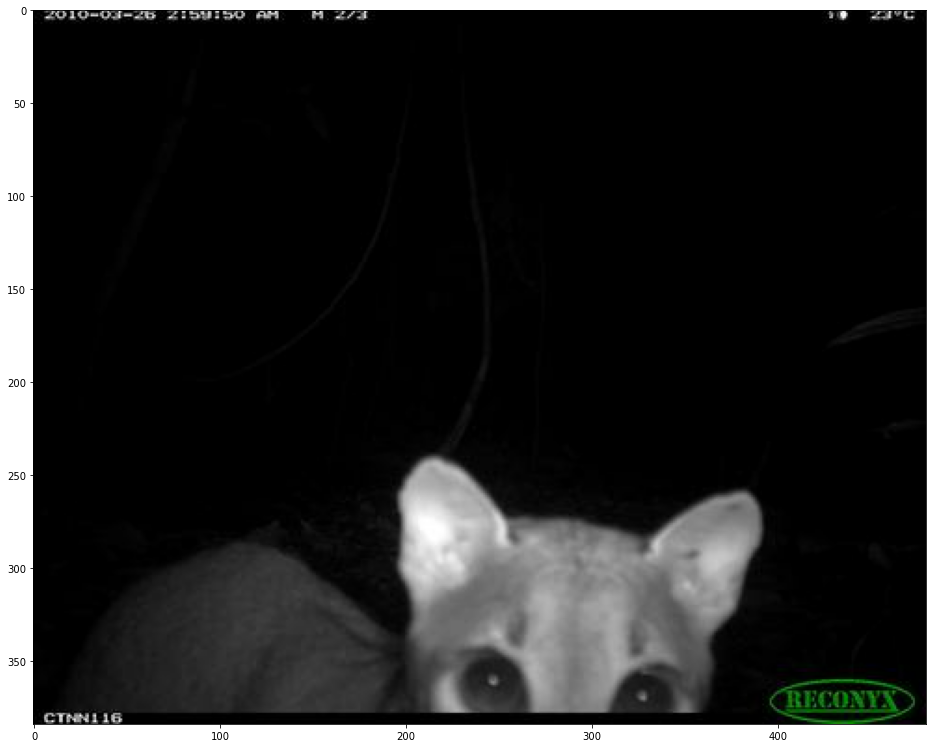

In [9]:
img = show_img(total[1][302290])

In [10]:
img

<tf.Tensor: shape=(384, 480, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.03529412, 0.03529412, 0.03529412]],

       [[0.04313726, 0.04313726, 0.04313726],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.05490196, 0.05490196, 0.05490196],
        [0.01960784, 0.01960784, 0.01960784],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.03529412, 0.03529412, 0.03529412],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.02745098, 0.02745098, 0.02745098]],

       ...,

       [[0.01176471, 0.01176471, 0.01176471],
        [0.02

# plot

In [ ]:
small_animal = ['Squirrel', 'Rodent', 'Chevrotain_Water', 'Porcupine_Brush_Tailed', 'Mongoose', 'Genet', 'Mongoose_Black_Footed', 'Civet_African_Palm', 'Pangolin', "Rat_Giant"]
Monkey = ['Monkey', 'Mandrillus', 'Chimpanzee', 'Gorilla']
duiker = ['Duiker_Blue', 'Duiker_Yellow_Backed']
Bird = ['Rail_Nkulengu', 'Bird', 'Guineafowl_Crested']
Hog_Red_River
Human
Elephant_African
Leopard_African
Buffalo_African
Cat_Golden <- removed

In [1]:
{'Rat_Giant':0.93, 'Squirrel':0.12, 'Duiker_Red':0.86, 'Rodent':0.05, 'Human':0.92,
       'Guineafowl_Black':0.68, 'Monkey':0.17, 'Duiker_Blue':0.82,
       'Duiker_Yellow_Backed':0.44, 'Elephant_African':0.80, 'Rail_Nkulengu':0.00,
       'Bird':0.08, 'Blank':0.77, 'Mandrillus':0.83, 'Chevrotain_Water':0.13,
       'Porcupine_Brush_Tailed':0.31, 'Leopard_African':0.85, 'Mongoose':0.12,
       'Hog_Red_River':0.72, 'Chimpanzee':0.50, 'Guineafowl_Crested':0.35,
       'Buffalo_African':0.20, 'Genet':0.30, 'Mongoose_Black_Footed':0.12,
       'Civet_African_Palm':0.02, 'Pangolin':0.03, 'Gorilla':0.28, 'Cat_Golden':0.03}

{'Rat_Giant': 0.93,
 'Squirrel': 0.12,
 'Duiker_Red': 0.86,
 'Rodent': 0.05,
 'Human': 0.92,
 'Guineafowl_Black': 0.68,
 'Monkey': 0.17,
 'Duiker_Blue': 0.82,
 'Duiker_Yellow_Backed': 0.44,
 'Elephant_African': 0.8,
 'Rail_Nkulengu': 0.0,
 'Bird': 0.08,
 'Blank': 0.77,
 'Mandrillus': 0.83,
 'Chevrotain_Water': 0.13,
 'Porcupine_Brush_Tailed': 0.31,
 'Leopard_African': 0.85,
 'Mongoose': 0.12,
 'Hog_Red_River': 0.72,
 'Chimpanzee': 0.5,
 'Guineafowl_Crested': 0.35,
 'Buffalo_African': 0.2,
 'Genet': 0.3,
 'Mongoose_Black_Footed': 0.12,
 'Civet_African_Palm': 0.02,
 'Pangolin': 0.03,
 'Gorilla': 0.28,
 'Cat_Golden': 0.03}

In [1]:
{'Rat_Giant':0.75, 'Squirrel':0.15, 'Duiker_Red':0.60, 'Rodent':0.11, 'Human':0.80,
       'Guineafowl_Black':0.48, 'Monkey':0.18, 'Duiker_Blue':0.55,
       'Duiker_Yellow_Backed':0.60, 'Elephant_African':0.70, 'Rail_Nkulengu':0.00,
       'Bird':0.17, 'Blank':0.75, 'Mandrillus':0.88, 'Chevrotain_Water':0.15,
       'Porcupine_Brush_Tailed':0.37, 'Leopard_African':0.87, 'Mongoose':0.34,
       'Hog_Red_River':0.54, 'Chimpanzee':0.60, 'Guineafowl_Crested':0.45,
       'Buffalo_African':0.41, 'Genet':0.40, 'Mongoose_Black_Footed':0.34,
       'Civet_African_Palm':0.12, 'Pangolin':0.12, 'Gorilla':0.78, 'Cat_Golden':0.71}

{'Rat_Giant': 0.75,
 'Squirrel': 0.15,
 'Duiker_Red': 0.6,
 'Rodent': 0.11,
 'Human': 0.8,
 'Guineafowl_Black': 0.48,
 'Monkey': 0.18,
 'Duiker_Blue': 0.55,
 'Duiker_Yellow_Backed': 0.6,
 'Elephant_African': 0.7,
 'Rail_Nkulengu': 0.0,
 'Bird': 0.17,
 'Blank': 0.75,
 'Mandrillus': 0.88,
 'Chevrotain_Water': 0.15,
 'Porcupine_Brush_Tailed': 0.37,
 'Leopard_African': 0.87,
 'Mongoose': 0.34,
 'Hog_Red_River': 0.54,
 'Chimpanzee': 0.6,
 'Guineafowl_Crested': 0.45,
 'Buffalo_African': 0.41,
 'Genet': 0.4,
 'Mongoose_Black_Footed': 0.34,
 'Civet_African_Palm': 0.12,
 'Pangolin': 0.12,
 'Gorilla': 0.78,
 'Cat_Golden': 0.71}